# AEWS Python Notebook 04: buffering WOFS data and basic band maths

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 28 April 2016 (slight update: July 15, 2016)

**Note**: The Python code below is "rudimentary". It does not make specific use of the API's Analytics / Execution Engines, nor is it optimised to take advantage of the subtleties of Python's xarrays, etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

In this notebook, we introduce / review the following concepts:

* loading Landsat data
* loading and reprojecting WOFS data
* creating a WOFS 90% water mask and buffering it to remove edge pixels
* carrying out basic band arithmetics on the Landsat data
* basic band arithmetics on the Landsat data using the AGDC v2.0 API Analytics & Execution engines.


## Preliminaries

Following up from the previous notebooks in this series, this Jupyter notebook is used to investigate the implementation of buffering of the WOFS data (removal of edge pixels, potentially affected by adjacency effects, mis-alignment, etc), followed by some basic band math operations on the resulting Landsat data. It will also test the functionality of the API's Execution engine for this purpose.

This notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```$ module use /g/data/v10/public/modules/modulefiles --append
$ module load agdc-py2-dev```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import math

from osgeo import gdal, osr, ogr

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Function: Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val'
    #  and 'max_val', replacing 'nan_val' values with NumPy NaN's.
    f_arr = arr.astype('float')    # required for NaN's 
    f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

## Loading some Landsat data

Let's load up some Landsat 5 data (using the AGDC v2.0 API), using here again the LBG region as an example.

In [2]:
dc = datacube.api.API()
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.06, 149.17) },
        'y' : { 'range': (-35.27, -35.33) },
    'time': { 'range': ((1996, 1, 1), (1996, 7 ,1)) }
    }
}
L5data = dc.get_data( query )

In [3]:
date_ind = 6   # select some time slice in the time sequence
B2data = L5data['arrays']['band_20'].isel(time=date_ind).values
B4data = L5data['arrays']['band_40'].isel(time=date_ind).values
B5data = L5data['arrays']['band_50'].isel(time=date_ind).values

In [4]:
# scale the data for display purpose, and create false colour image
sB2data = scale_array(B2data, 99.0, 0, 255, -999)
sB4data = scale_array(B4data, 99.0, 0, 255, -999)
sB5data = scale_array(B5data, 99.0, 0, 255, -999)
y_size = L5data['size'][1]; x_size = L5data['size'][2]
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data; FC_image[:,:,1] = sB4data; FC_image[:,:,2] = sB2data

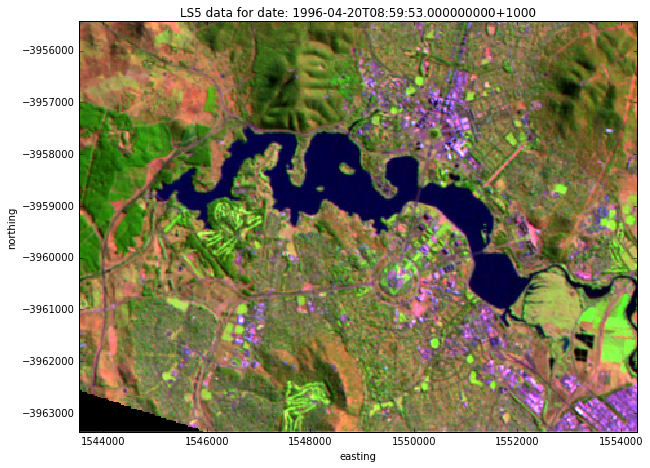

In [5]:
# display the data
cur_date = L5data['indices']['time'][date_ind]
L5xvec = L5data['indices']['x']
L5yvec = L5data['indices']['y']
plt.imshow(FC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('LS5 data for date: {}'.format(cur_date))
plt.ylabel('northing'); plt.xlabel('easting');

## Loading the WOFS data

As shown in the previous series notebook, we can use `rasterio` or `gdal` to access and process geoTiff data. For illustration, here we'll use `gdal` to load up the WOFS data corresponding to the above Landsat image.

In [6]:
# Define a coordinate transformtion to/from WOFS projection and Landsat projection:
WOFS_proj = osr.SpatialReference()
WOFS_proj.ImportFromEPSG( 4326 )    # WGS84 -- geodetic WOFS coordinates
L5_proj_str = L5data['coordinate_reference_systems'][1]['reference_system_definition']    # string
L5_proj = osr.SpatialReference()
L5_proj.ImportFromWkt( L5_proj_str )
to_wofs_tx = osr.CoordinateTransformation( L5_proj, WOFS_proj )
to_L5_tx = osr.CoordinateTransformation( WOFS_proj, L5_proj )

In [7]:
LBG_latlon = to_wofs_tx.TransformPoint( L5xvec.mean(), L5yvec.mean(), 0 )   # approx. coords of LBG
base_folder = '/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/'   # where geoTiff WOFS data is located
WOFStile_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( LBG_latlon[0], math.floor(LBG_latlon[1]) )

WOFStile_dataset = gdal.Open(WOFStile_fname)
WOFStile_array = WOFStile_dataset.ReadAsArray()
WOFStile_geotx = WOFStile_dataset.GetGeoTransform()

Create a new dataset (subset) with only LBG...

In [8]:
xind_min = 950; xind_max = 1450; dx = xind_max - xind_min + 1
yind_min = 100; yind_max = 850; dy = yind_max - yind_min + 1
subs_array = WOFStile_array[xind_min:(xind_max+1),yind_min:(yind_max+1)]

subs_geotx = list( WOFStile_geotx )
subs_geotx[0] = subs_geotx[0] + yind_min*subs_geotx[1]
subs_geotx[3] = subs_geotx[3] + xind_min*subs_geotx[5]

geoWOFSsubs_data = gdal.GetDriverByName('MEM').Create('', int(dy), int(dx), 1, gdal.GDT_Float32)
geoWOFSsubs_data.SetGeoTransform( subs_geotx )
geoWOFSsubs_data.SetProjection( WOFStile_dataset.GetProjectionRef() )  # same projection
geoWOFSsubs_data.GetRasterBand(1).WriteArray(subs_array, 0, 0)

WOFStile_lonvec = np.arange(WOFStile_array.shape[0]) * WOFStile_geotx[1] + WOFStile_geotx[0]
WOFStile_latvec = np.arange(WOFStile_array.shape[1]) * WOFStile_geotx[5] + WOFStile_geotx[3]

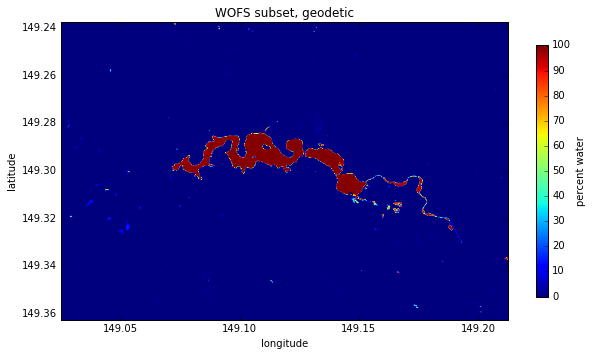

In [9]:
plt.imshow( subs_array, extent=[WOFStile_lonvec[yind_min], WOFStile_lonvec[yind_max],
                                WOFStile_lonvec[xind_max], WOFStile_lonvec[xind_min]] )
plt.title("WOFS subset, geodetic"); plt.xlabel('longitude'); plt.ylabel('latitude')
plt.colorbar(orientation='vertical', shrink=0.45, label='percent water');

Reprojecting WOFS using `gdal`...

In [10]:
L5pix_size = np.mean(L5xvec[1:] - L5xvec[:-1])   # determined from the data...

( ulx, uly, ulz ) = (L5xvec[0]-5000, L5yvec[0]+5000, 0.0)
( lrx, lry, lrz ) = (L5xvec[-1]+5000, L5yvec[-1]-5000, 0.0)
dx = int((lrx-ulx)/L5pix_size); dy = int((uly-lry)/L5pix_size)

mem_drv = gdal.GetDriverByName( 'MEM' )
reprWOFSsubs_data = mem_drv.Create('', dx, dy, 1, gdal.GDT_Float32)

new_geotx = ( ulx, L5pix_size, 0, uly, 0, -L5pix_size )
reprWOFSsubs_data.SetGeoTransform( new_geotx )
reprWOFSsubs_data.SetProjection( L5_proj.ExportToWkt() )

reprWOFSsubs_xvec = np.arange(dx)*new_geotx[1] + new_geotx[0] 
reprWOFSsubs_yvec = np.arange(dy)*new_geotx[5] + new_geotx[3]

reprWOFSsubs_data.GetRasterBand(1).WriteArray( np.ones((dy,dx))*np.nan, 0, 0)
res = gdal.ReprojectImage( geoWOFSsubs_data, reprWOFSsubs_data, 
                           WOFS_proj.ExportToWkt(), L5_proj.ExportToWkt(), 
                           gdal.GRA_Bilinear )  # gdal.GRA_NearestNeighbour by default

reprWOFSsubs_array = reprWOFSsubs_data.ReadAsArray()

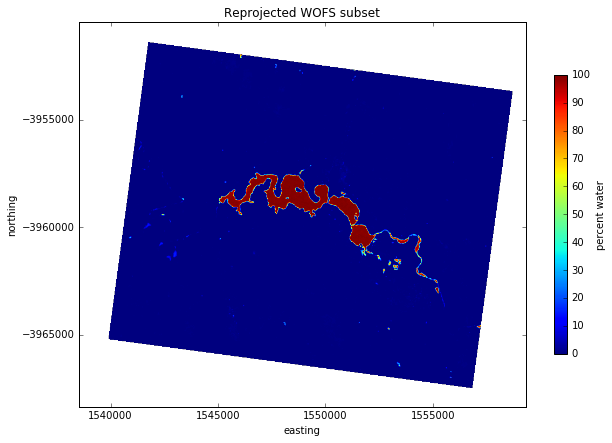

In [11]:
plt.imshow(reprWOFSsubs_array, extent=[ulx, lrx, lry, uly])
plt.title('Reprojected WOFS subset')
plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='percent water');

Further cropping of the reprojected WOFS data to the extents of the Landsat grid.

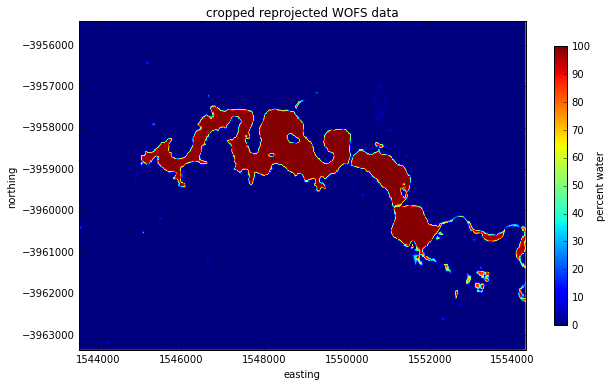

In [12]:
crop_xind1 = np.where(reprWOFSsubs_xvec==L5xvec[0])[0][0]
crop_xind2 = np.where(reprWOFSsubs_xvec==L5xvec[-1])[0][0]
crop_yind1 = np.where(reprWOFSsubs_yvec==L5yvec[0])[0][0]
crop_yind2 = np.where(reprWOFSsubs_yvec==L5yvec[-1])[0][0]

reprWOFScrop_xvec = reprWOFSsubs_xvec[crop_xind1:(crop_xind2+1)]
reprWOFScrop_yvec = reprWOFSsubs_yvec[crop_yind1:(crop_yind2+1)]

reprWOFScrop_array = np.copy( reprWOFSsubs_array[crop_yind1:crop_yind2+1, crop_xind1:crop_xind2+1] )

plt.imshow( reprWOFScrop_array, extent=[reprWOFScrop_xvec[0], reprWOFScrop_xvec[-1], 
                                        reprWOFScrop_yvec[-1], reprWOFScrop_yvec[0]], aspect=1, interpolation='none' ) 
plt.title("cropped reprojected WOFS data"); plt.xlabel('easting'); plt.ylabel('northing');
plt.colorbar(orientation='vertical', shrink=0.5, label='percent water');

## Masking land pixels out

Creating the WOFS mask and masking the Landsat data accordingly:

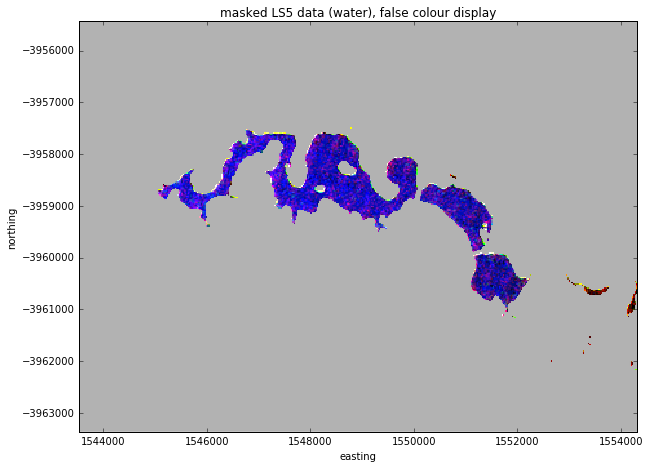

In [13]:
land_mask = (reprWOFScrop_array<=90)

msB2data = np.copy(sB2data)
msB2data[land_mask] = np.nan; msB2data = scale_array(msB2data, 95.0, 0, 1, np.nan)
msB4data = np.copy(sB4data)
msB4data[land_mask] = np.nan; msB4data = scale_array(msB4data, 95.0, 0, 1, np.nan)
msB5data = np.copy(sB5data)
msB5data[land_mask] = np.nan; msB5data = scale_array(msB5data, 95.0, 0, 1, np.nan)

# making the masked values appear light grey instead of black:
msB2data[np.isnan(msB2data)] = .7; msB4data[np.isnan(msB4data)] = .7; msB5data[np.isnan(msB5data)] = .7

mFC_image = np.ones((y_size, x_size, 3), dtype='float32') #uint8')
mFC_image[:,:,0] = msB5data; mFC_image[:,:,1] = msB4data; mFC_image[:,:,2] = msB2data

plt.imshow(mFC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('masked LS5 data (water), false colour display'); plt.ylabel('northing'); plt.xlabel('easting');

## Refining the water mask

As seen above, there are some "dodgy" pixels around the edges of the lake. These may be due to adjacency effects (influence of nearby structures or vegetation on the edge pixels), or a result of a shallow(er) water depth on a particular date (bottom of lake visible in optically shallow pixels).

Let's write a small function to "expand" the land mask so as to als remove these affected (water) edge pixels.

In [14]:
from scipy import ndimage
from scipy.spatial.distance import pdist

def expand_mask(mask_arr, npix):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    return ndimage.binary_dilation(mask_arr, structure=struc)

Let's test our expanded land mask and plot it...

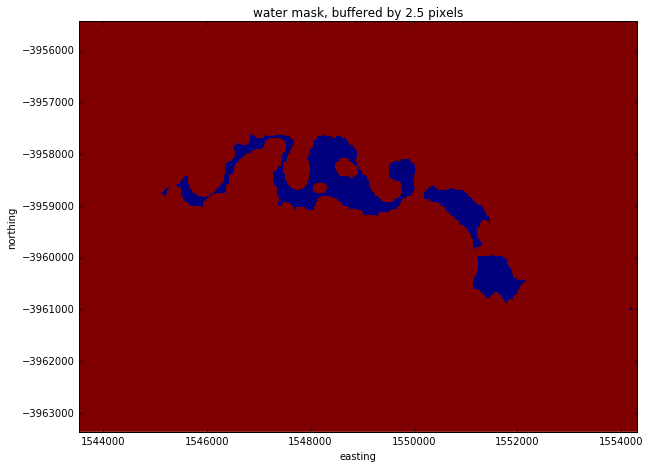

In [15]:
plt.imshow(expand_mask(land_mask,2.5), interpolation='none', 
           extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('water mask, buffered by 2.5 pixels'); plt.ylabel('northing'); plt.xlabel('easting');

Looks OK, though of course too much has been removed here. And now for the masked Landsat data...

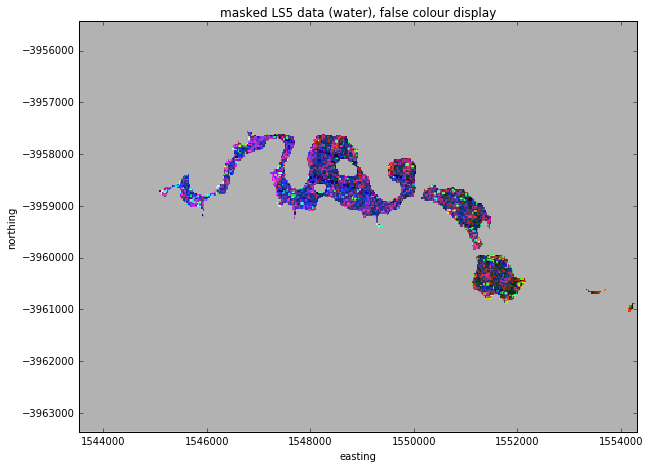

In [16]:
buffer_dist = 1.5   # buffer width in pixels to expand the land mask by
exp_land_mask = expand_mask(land_mask,buffer_dist)

emsB2data = np.copy(sB2data)
emsB2data[exp_land_mask] = np.nan; emsB2data = scale_array(emsB2data, 95.0, 0, 1, np.nan)
emsB4data = np.copy(sB4data)
emsB4data[exp_land_mask] = np.nan; emsB4data = scale_array(emsB4data, 95.0, 0, 1, np.nan)
emsB5data = np.copy(sB5data)
emsB5data[exp_land_mask] = np.nan; emsB5data = scale_array(emsB5data, 95.0, 0, 1, np.nan)

emsB2data[np.isnan(emsB2data)] = .7; emsB4data[np.isnan(emsB4data)] = .7; emsB5data[np.isnan(emsB5data)] = .7

emFC_image = np.ones((y_size, x_size, 3), dtype='float32')
emFC_image[:,:,0] = emsB5data; emFC_image[:,:,1] = emsB4data; emFC_image[:,:,2] = emsB2data

plt.imshow(emFC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('masked LS5 data (water), false colour display'); plt.ylabel('northing'); plt.xlabel('easting');

Looks about right... The edge pixels have been removed, and the detail of the "true" water pixels is now more apparent (a different display, better taylored to waterbodies, might be preferable here!).

Of course, we could fiddle with the buffering more if desired:

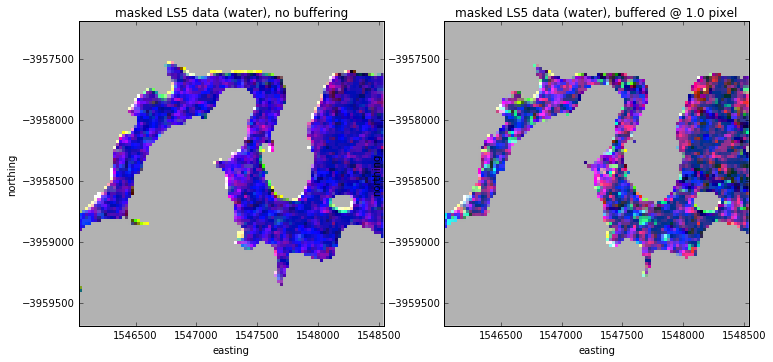

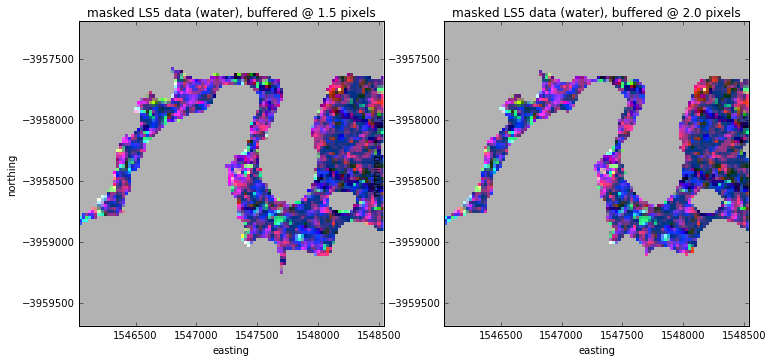

In [17]:
xi1 = 100; xi2 = 200; yi1 = 70; yi2 = 170   # some zoom extents

# original image:
plt.figure(figsize=(12,6)); plt.subplot( 1,2,1 )
exp_land_mask = expand_mask(land_mask,0)
emsB2data = np.copy(sB2data); emsB2data[exp_land_mask] = np.nan; emsB2data = scale_array(emsB2data, 95.0, 0, 1, np.nan)
emsB4data = np.copy(sB4data); emsB4data[exp_land_mask] = np.nan; emsB4data = scale_array(emsB4data, 95.0, 0, 1, np.nan)
emsB5data = np.copy(sB5data); emsB5data[exp_land_mask] = np.nan; emsB5data = scale_array(emsB5data, 95.0, 0, 1, np.nan)
emsB2data[np.isnan(emsB2data)] = .7; emsB4data[np.isnan(emsB4data)] = .7; emsB5data[np.isnan(emsB5data)] = .7
emFC_image = np.ones((y_size, x_size, 3), dtype='float32')
emFC_image[:,:,0] = emsB5data; emFC_image[:,:,1] = emsB4data; emFC_image[:,:,2] = emsB2data
plt.imshow(emFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
           extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1)
plt.title('masked LS5 data (water), no buffering'); plt.ylabel('northing'); plt.xlabel('easting');

# buffered @ 1.0 pixel:
plt.subplot( 1,2,2 )
exp_land_mask = expand_mask(land_mask,1.0)
emsB2data = np.copy(sB2data); emsB2data[exp_land_mask] = np.nan; emsB2data = scale_array(emsB2data, 95.0, 0, 1, np.nan)
emsB4data = np.copy(sB4data); emsB4data[exp_land_mask] = np.nan; emsB4data = scale_array(emsB4data, 95.0, 0, 1, np.nan)
emsB5data = np.copy(sB5data); emsB5data[exp_land_mask] = np.nan; emsB5data = scale_array(emsB5data, 95.0, 0, 1, np.nan)
emsB2data[np.isnan(emsB2data)] = .7; emsB4data[np.isnan(emsB4data)] = .7; emsB5data[np.isnan(emsB5data)] = .7
emFC_image = np.ones((y_size, x_size, 3), dtype='float32')
emFC_image[:,:,0] = emsB5data; emFC_image[:,:,1] = emsB4data; emFC_image[:,:,2] = emsB2data
plt.imshow(emFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
           extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1)
plt.title('masked LS5 data (water), buffered @ 1.0 pixel'); plt.ylabel('northing'); plt.xlabel('easting');

# buffered @ 1.5 pixels:
plt.figure(figsize=(12,6)); plt.subplot( 1,2,1 )
exp_land_mask = expand_mask(land_mask,1.5)
emsB2data = np.copy(sB2data); emsB2data[exp_land_mask] = np.nan; emsB2data = scale_array(emsB2data, 95.0, 0, 1, np.nan)
emsB4data = np.copy(sB4data); emsB4data[exp_land_mask] = np.nan; emsB4data = scale_array(emsB4data, 95.0, 0, 1, np.nan)
emsB5data = np.copy(sB5data); emsB5data[exp_land_mask] = np.nan; emsB5data = scale_array(emsB5data, 95.0, 0, 1, np.nan)
emsB2data[np.isnan(emsB2data)] = .7; emsB4data[np.isnan(emsB4data)] = .7; emsB5data[np.isnan(emsB5data)] = .7
emFC_image = np.ones((y_size, x_size, 3), dtype='float32')
emFC_image[:,:,0] = emsB5data; emFC_image[:,:,1] = emsB4data; emFC_image[:,:,2] = emsB2data
plt.imshow(emFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
           extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1)
plt.title('masked LS5 data (water), buffered @ 1.5 pixels'); plt.ylabel('northing'); plt.xlabel('easting');

# buffered @ 2.0 pixels:
plt.subplot( 1,2,2 )
exp_land_mask = expand_mask(land_mask,2.0)
emsB2data = np.copy(sB2data); emsB2data[exp_land_mask] = np.nan; emsB2data = scale_array(emsB2data, 95.0, 0, 1, np.nan)
emsB4data = np.copy(sB4data); emsB4data[exp_land_mask] = np.nan; emsB4data = scale_array(emsB4data, 95.0, 0, 1, np.nan)
emsB5data = np.copy(sB5data); emsB5data[exp_land_mask] = np.nan; emsB5data = scale_array(emsB5data, 95.0, 0, 1, np.nan)
emsB2data[np.isnan(emsB2data)] = .7; emsB4data[np.isnan(emsB4data)] = .7; emsB5data[np.isnan(emsB5data)] = .7
emFC_image = np.ones((y_size, x_size, 3), dtype='float32')
emFC_image[:,:,0] = emsB5data; emFC_image[:,:,1] = emsB4data; emFC_image[:,:,2] = emsB2data
plt.imshow(emFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
           extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1)
plt.title('masked LS5 data (water), buffered @ 2.0 pixels'); plt.ylabel('northing'); plt.xlabel('easting');

## Band maths: "basic" method

The first AEWS prototype will be based on simple band arithmetics using Landsat data. Using the above bits of code, we can achieve this as follows.

In [18]:
%%time
date_ind = 6
B2data = L5data['arrays']['band_20'].isel(time=date_ind).values
B3data = L5data['arrays']['band_30'].isel(time=date_ind).values
WQ_index = (B2data + B3data) * 0.5

CPU times: user 4.53 s, sys: 582 ms, total: 5.11 s
Wall time: 5.11 s


The code in the above cell is where the Landsat data is read / loaded up and then processed. Here, this seems to be using in the order of ~5s to execute.

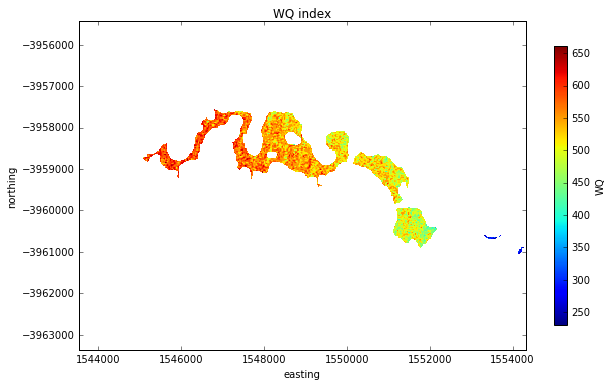

In [19]:
exp_land_mask = expand_mask(land_mask,1.5)
WQ_index[exp_land_mask] = np.nan

plt.imshow(WQ_index, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('WQ index'); plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

## Band maths: using the Analytics / Execution engines

We can do the same using the AGDC v2.0 Execution Engine, which should enable a more efficient / faster execution of the code. 

Extracted from [X. Ho's notebook](https://github.com/Spaxe/agdc-v2/blob/spaxe/contrib-example/contrib/notebooks/CSIRO%20Water%20Quality%20Analysis%20using%20Turbidity%20.ipynb): To set up the Engine, we first need to instantiate the modules and setup query parameters.

* **create_array** sets up the platform and product we are interested in querying, as well as the bands (variables) of the satellite data set. We also limit the amount of data processed by a long/lat boundary and temporal window.
* **apply_expression** binds the variables into a generic string to execute, in this case an average of two bands.
* **execute_plan** is when the computation is actually run and returned.


In [20]:
from datetime import datetime
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine
from datacube.analytics.utils.analytics_utils import plot
ae = AnalyticsEngine()
ee = ExecutionEngine()

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [21]:
%%time
dimensions = { 'longitude': {'range': (149.06, 149.17)},
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      {'range': ((1996, 1, 1), (1996, 7 ,1))} }

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')

ee.execute_plan(ae.plan)

CPU times: user 323 ms, sys: 12 ms, total: 335 ms
Wall time: 385 ms


Here, the Analytics / Execution Engine allows us to read and process 11 times more data (the WQ expression / formula is applied to *all* 11 dates in the selected time window) in over 10 times less time than the above approach... Sounds like a pretty good reason to implement the algorithm using these engines! 

**UPDATE** (July 2016): Subsequent tests (see _'AEWS Python Notebook 08i'_) indicate that the AE/EE execution time above likely does NOT actually include time taken by the calculation phase (only includes the setup phase). Taking this into account demonstrates that the AE/EE execution times are actually on a par with those of the "low-level" API functions above.

plot3D


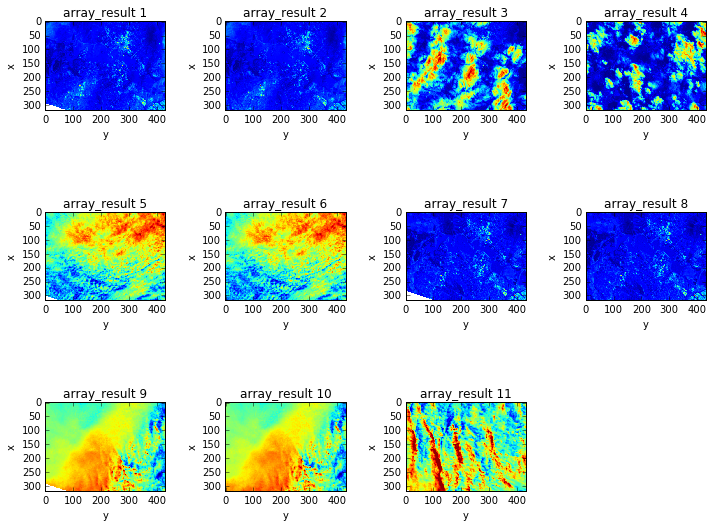

In [22]:
plot(ee.cache['aeWQ'])

<type 'dict'>  with keys: ['aeWQ', 'aeB2', 'aeB3']
<type 'dict'>  with keys: ['array_result', 'array_indices', 'array_dimensions', 'array_output']


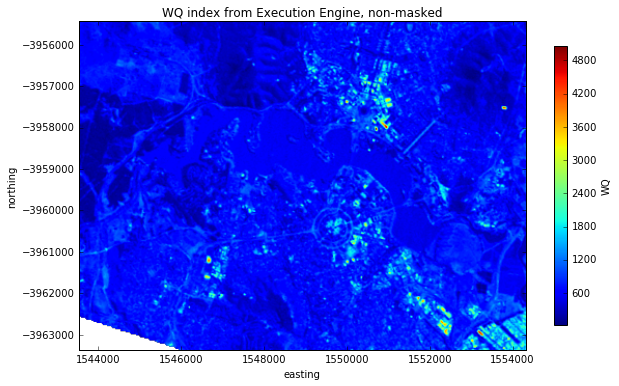

In [23]:
print( type(ee.cache), " with keys:", ee.cache.keys() )
print( type(ee.cache['aeWQ']), " with keys:",  ee.cache['aeWQ'].keys() )

xvec = ee.cache['aeWQ']['array_indices']['x']
yvec = ee.cache['aeWQ']['array_indices']['y']
WQ_array = ee.cache['aeWQ']['array_result']['aeWQ'][date_ind].values
plt.imshow( WQ_array, extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title('WQ index from Execution Engine, non-masked'); plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

In [24]:
print( exp_land_mask.shape )
print( WQ_array.shape )

(318, 432)
(318, 432)


... and we even have the same dataset sizes! :)

We can even do the same computations using masked datasets (with PQ information):

In [25]:
# new arrays defined here are simply added to the existing "plan" and existing variables...
aePQ = ae.create_array(('LANDSAT_5', 'PQ'), ['band_pixelquality'], dimensions, 'aePQ')
aeWQ_masked = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_masked')
ee.execute_plan(ae.plan)

['aeWQ', 'aePQ', 'aeWQ_masked', 'aeB2', 'aeB3']
plot3D


/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


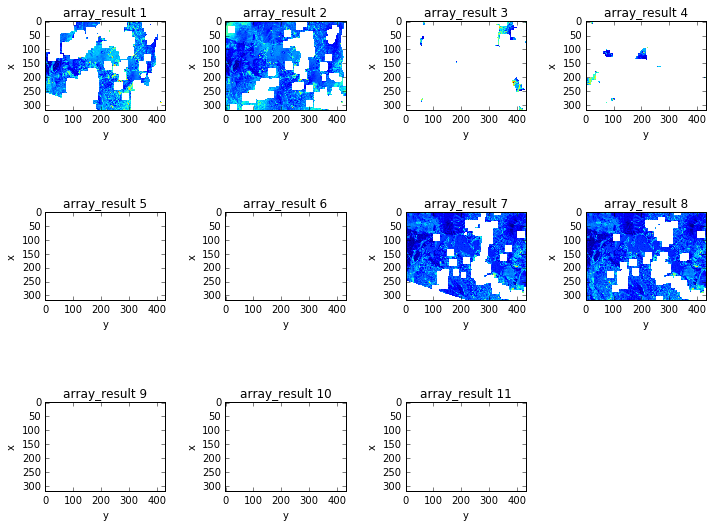

In [26]:
print( ee.cache.keys() )
plot( ee.cache['aeWQ_masked'] )

... although the results seem somewhat suspicious (square blobs of masked pixels). This might need further investigating, and we'll have to use our own PQ masks in the meantime (see "AEWS Python Notebook 02" in this series).

## Summing up: masked band maths with Analytics / Execution engines

Using the above Execution Engine results (`WQ_array`) and previously computed, WOFS-based expanded land mask, we can simply generate the WQ information as above:

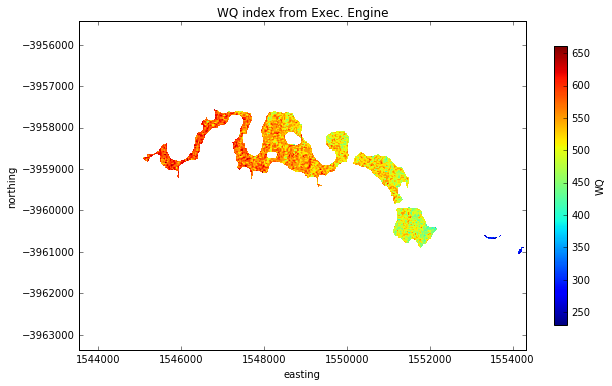

In [27]:
WQ_array[exp_land_mask] = np.nan

plt.imshow(WQ_array, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('WQ index from Exec. Engine'); plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');